# Spacial Analysis of Capital Bikeshare Trips 2019

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os
from pathlib import Path
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Data

Capital Bikeshare trips history data is available on [their website](https://www.capitalbikeshare.com/system-data). The data goes back to 2010 and has the following columns:

   * Duration – Duration of trip
   * Start Date – Includes start date and time
   * End Date – Includes end date and time
   * Start Station – Includes starting station name and number
   * End Station – Includes ending station name and number
   * Bike Number – Includes ID number of bike used for the trip
   * Member Type – Indicates whether user was a "registered" member (Annual Member, 30-Day Member or Day Key Member) or a "casual" rider (Single Trip, 24-Hour Pass, 3-Day Pass or 5-Day Pass)
   
In addition, they have cleaned the data to exclude trips taken by the staff and trips that lasted less than a minute, potentially due to false starts or the user unintentionally redocking it. 

Meta data on stations are sourced from [Open Data DC](https://opendata.dc.gov/datasets/capital-bike-share-locations/geoservice). I grab:
    
   * Terminal number
   * Longitude
   * Latitude
   * Address
   * Number of empty docks
   * Number of bikes
    
I download the data using their API. I'm not sure how frequent the updates are, but if it's frequent enough, this data can be used to construct downtime(when a station is full, empty or unavailable to use) as well. 


Both data are pretty clean and easy to use. See modules/preprocess_data.py to see the details on how I downlaod and process them.


If you are interested in deepdiving into the use of Capital Bikeshare, check out [this very rich and detailed development plan from DDT (2016)](https://www.scribd.com/document/331416467/Bikeshare-Development-Plan#from_embed) which combines the trips data with other sources on membership, downtime, neighborhood, and spacial data to create a comprehensive roadmap for the program's impact and expansion. In addition, member survey reports are available on Capital Bikeshare on the same page as their trips data, which provides information that can't otherwise be gathered from use data. 

In [3]:
from modules import preprocess_data
since2019 = [Path(os.getcwd(), 'data', 'raw', f) for f in os.listdir('data/raw') if f.startswith(('2019'))]
trips, stations = preprocess_data.master_data(since2019)

In trips(start) but not in stations: [31202 32031 31008 32051     0], 19,618 trips total
Dropping trips that are not in stations data for now.
In trips(end) but not in stations: [31202 32031 31008 32051     0], 21,076 trips total
Dropping trips that not in stations data for now.


In [43]:
# for scripting purpose
df = trips.sample(20000)

### Most popular routes

In [5]:
popular_routes = df.groupby(['start_station', 'end_station']).size().rename('trips').to_frame()
popular_routes.sort_values('trips', ascending=False).head(20)

trips
start_station                                      end_station                                              
Smithsonian-National Mall / Jefferson Dr & 12th... Smithsonian-National Mall / Jefferson Dr & 12th...   4912
Columbus Circle / Union Station                    6th & H St NE                                        4355
6th & H St NE                                      Columbus Circle / Union Station                      3590
4th St & Madison Dr NW                             4th St & Madison Dr NW                               3528
Jefferson Dr & 14th St SW                          Jefferson Dr & 14th St SW                            3522
Columbus Circle / Union Station                    8th & F St NE                                        3513
Lincoln Memorial                                   Jefferson Memorial                                   3466
Jefferson Dr & 14th St SW                          Lincoln Memorial                                     3066
8th & F St NE                                      Columbus Circle / Union Station                      2976
Smithsonian-National Mall / Jefferson Dr & 12th... Lincoln Memorial                                     2899
15th St & Constitution Ave NW                      15th St & Constitution Ave NW                        2882
17th St & Independence Ave SW                      Lincoln Memorial                                     2868
Henry Bacon Dr & Lincoln Memorial Circle NW        Henry Bacon Dr & Lincoln Memorial Circle NW          2683
Lincoln Memorial                                   Lincoln Memorial                                     2567
17th St & Independence Ave SW                      17th St & Independence Ave SW                        2559
14th & Irving St NW                                11th & Girard St NW                                  2526
Gravelly Point                                     Gravelly Point                                       2429
Lincoln Memorial                                   Jefferson Dr & 14th St SW                            2425
Eastern Market Metro / Pennsylvania Ave & 7th S... Lincoln Park / 13th & East Capitol St NE             2375
Maryland Ave & E St NE                             Columbus Circle / Union Station                      2333

> The most popular route is from and to Smithonian, most likely tourists taking the bikes out for a ride around the mall. The routes between the Union Station and 6th & H are second and third most popular--surprising because the H street area is not traditionally thought of as the tourist area. Most of the most popular routes are around downtown and the National Mall.

## Most popular stations by either starting or ending a trip

In [83]:
def create_routes_table(df, stations_data, query_txt=None):
    
    if query_txt:
        df = df.query(query_txt)
           
    start = df.groupby(['start_station_id']).size().rename('usage')
    end = df.groupby(['end_station_id']).size().rename('usage')

    s = pd.merge(start, end, 'outer', left_index=True, right_index=True, suffixes=['_start', '_end'])

    # merge with stations data to get station meta data
    s = pd.merge(s, stations_data, 'left', left_index=True, right_on='station_id')

    s['usage_start'] = s['usage_start'].fillna(0)
    s['usage_end'] = s['usage_end'].fillna(0)
    s['usage'] = s['usage_start'] + s['usage_end']
    s['deficit'] = s['usage_start'] - s['usage_end']  
    
    return(s)

s_use = create_routes_table(df, stations)
print("Most popular stations by usage (starting or ending trips)")
s_use[['address', 'usage']].sort_values('usage', ascending=False).head(20)

Most popular stations by usage (starting or ending trips)


address  usage
550                    Columbus Circle / Union Station  725.0
250        Henry Bacon Dr & Lincoln Memorial Circle NW  416.0
20                           Jefferson Dr & 14th St SW  408.0
56                                    Lincoln Memorial  405.0
21   Smithsonian-National Mall / Jefferson Dr & 12t...  399.0
249                             4th St & Madison Dr NW  391.0
488               Massachusetts Ave & Dupont Circle NW  384.0
462                                     15th & P St NW  378.0
539                        New Hampshire Ave & T St NW  357.0
489                                      1st & M St NE  354.0
454                                     14th & V St NW  353.0
30                                  Jefferson Memorial  352.0
515  Eastern Market Metro / Pennsylvania Ave & 7th ...  345.0
569                                      Thomas Circle  312.0
259                                14th & Irving St NW  311.0
463                         14th & Rhode Island Ave NW  302.0
251                      17th St & Independence Ave SW  284.0
529                                      8th & H St NW  270.0
540                      Metro Center / 12th & G St NW  269.0
469                                      5th & K St NW  265.0

# Stations

In [74]:
s_use.head()

usage_start  usage_end  station_id  \
441         13.0        9.0       31000   
442         12.0       13.0       31001   
443         31.0       36.0       31002   
444         23.0       26.0       31003   
445         17.0       20.0       31004   

                                          address   latitude  longitude  \
441                           Eads St & 15th St S  38.858971 -77.053230   
442                           18th St & S Eads St  38.857250 -77.053320   
443                        Crystal Dr & 20th St S  38.856425 -77.049232   
444                        Crystal Dr & 15th St S  38.860170 -77.049593   
445  Aurora Hills Cmty Ctr / 18th St & S Hayes St  38.857866 -77.059490   

     capacity  usage  
441        15   22.0  
442        10   25.0  
443        16   67.0  
444        10   49.0  
445        11   37.0

Text(0.5, 1.0, 'ECDF of Station Usage')

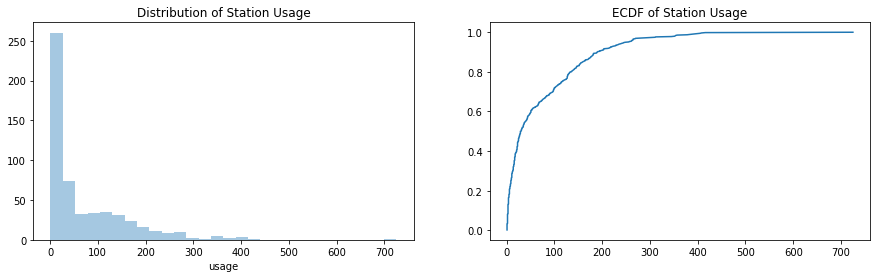

In [75]:
def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.distplot(a=s_use.usage, kde=False, ax=ax[0])
usage, cum_prob = ecdf(s_use.usage)
ax[1].plot(usage, cum_prob)
ax[0].set_title("Distribution of Station Usage")
ax[1].set_title("ECDF of Station Usage")

> The usage distribution is heavily left-skewed, indicating few get disporportionate amount of use. More than half of the stations had less than 10000 uses in 2019.

# Station Usage Mapping

After unsuccessfully playing with overlaying scatter plots over a DC shapefile, I settled on [folium](https://python-visualization.github.io/folium/), a mapping package built on Leaflet.js. The API is easy to use, and you can do a lot with just a few lines of code. It is most well suited for heatmaps, but since Capital Bikeshare trips are made between stations on discrete pairs of longitude and lattitude, I decided heatmaps are misleading to represent this data. Instead, I visualize aggregated metrics by stations. Because EDA revealed different patterns by members and casual users, I create visualizations separately for the two groups. 

In [91]:
import folium
from folium import plugins

def scale(s, scale_to):
    """ Scale a vector onto the range in scale_to tuple"""
    s_scale = np.interp(s, (s.min(), s.max()), scale_to)
    return(s_scale)

def create_stations_map(df):
    """ create a folium map """
    m = folium.Map(location=[38.90, -77.03],
            tiles='Stamen Toner',
            zoom_start=11.5,
            min_zoom=11,
            max_zoom=15)

    markers_params_0 = {'fill_color':'#E72C04','opacity':0.8, 'fill_opacity':0.6, 'stroke':False}
    markers_params_1 = {'fill_color':'#0984F0','opacity':0.8, 'fill_opacity':0.6, 'stroke':False} 
    for row in df.iterrows():
        tooltip = "{} : {:.0f}".format(row[1].address, row[1].usage)
        markers_params = markers_params_0 if row[1].deficit < 0 else markers_params_1
        folium.CircleMarker([row[1].latitude, row[1].longitude], 
                            row[1].usage_scale, None, tooltip,
                           **markers_params).add_to(m)
    return(m)

s_use_m = create_routes_table(df, stations, query_txt='member_type=="Member"')
s_use_m['usage_scale'] = scale(s_use_m.usage, (1, 20))
print("Station Map by Usage: Members Only")
create_stations_map(s_use_m)

Station Map by Usage: Members Only


> The marker size is proportional to usage (both start and end) and the color shows whether that station had more end trips then start trips (red) or vice versa (blue). As anyone who used the app during the peak commute hours can attest, the areas that see large volumns of inbound trips are not only Downtown and City Center, but also Georgetown, H street corridor, and Navy Yard.

> A zoomed out map shows the expansion of Capital Bikeshare stations into the suburbs in all directions. Prominent and continuous lines of station can be seen along Clarandon Boulevard in Northern Virginia and along Wisconsin Avenue beyond Chevy Chase, both more outbound then inbound. South of DC, clusters of mostly red dots show that Crystal City and Alexandria are destinations rather than origins. To the east of DC, Mount Rainers and Anacostina have stations, but the usage and connectivity are low.

In [90]:
s_use_m = create_routes_table(df, stations, query_txt='member_type=="Casual"')
s_use_m['usage_scale'] = scale(s_use_m.usage, (1, 20))
s_use_m['deficit'] = s_use_m['usage_start'] - s_use_m['usage_end']  
print("Station Map by Usage: Casual Riders Only")
create_stations_map(s_use_m)

Station Map by Usage: Members Only


## Routes Mapping

Map routes by member type for a week in July when the ridership peaks for both members and casual riders. 

In [92]:
def get_routes_subset(df, query_txt):
    """ Subset df by query_txt, create trip counts by routes, and scale trip counts """
    df_sub = df.query(query_txt).groupby(['start_station', 'end_station', 'latitude_start', \
                     'longitude_start', 'latitude_end', 'longitude_end']).size() \
            .rename('trips').to_frame().reset_index()
    df_sub['trips_scale'] = scale(df_sub.trips, (0, 1))
    return(df_sub)
    
def create_routes_map(data):
    """ Create a folium map """
    m = folium.Map(location=[38.90, -77.03],
                tiles='Stamen Toner',
                zoom_start=11.5,
                min_zoom=11,
                max_zoom=15)

    for row in data.iterrows():
        points = [(row[1].latitude_start, row[1].longitude_start), (row[1].latitude_end, row[1].longitude_end)]
        folium.PolyLine(points, color="red", opacity=row[1].trips_scale).add_to(m)

    return(m)

In [115]:
print("Members")
create_routes_map(get_routes_subset(df, 'member_type=="Member" and month==7 and week== 28'))

Members


In [114]:
print("Casual Members")
create_routes_map(get_subset(df, 'member_type=="Casual" and month==7 and week==28'))

Casual Members


In [85]:
import networkx as nx
import mpld3

popular_routes = df.query('hour.isin([6,7,8]) & member_type=="Member"').groupby(['start_station', 'end_station']).size().rename('trips').to_frame()
popular_routes.sort_values('trips', ascending=False)
pr = popular_routes.reset_index()

#pr['trips'] = np.log(pr.trips)
pr['trips'] = np.interp(pr.trips, (pr.trips.min(), pr.trips.max()), (0.5, 1))


G=nx.from_pandas_edgelist(pr, 'start_station', 'end_station', ['trips'])
pos = nx.spring_layout(G)

fig, ax = plt.subplots(figsize=(9, 9))
params = {'node_size':10}
edges, weights = zip(*nx.get_edge_attributes(G,'trips').items())
scatter = nx.draw_networkx_nodes(G, pos, ax=ax, **params)
nx.draw_networkx_edges(G, pos, edge_color=weights, ax=ax, edge_cmap=plt.cm.get_cmap('viridis'))

labels = G.nodes()
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

/Users/chungkim/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/chungkim/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/chungkim/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


In [91]:
import community
partition = community.best_partition(G)

/Users/chungkim/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/chungkim/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


ValueError: edge_color must be a color or list of one color per edge

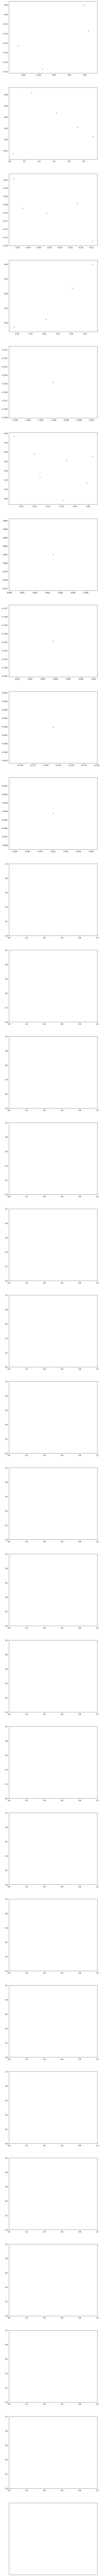

In [104]:
# #other example to display a graph with its community :
# #better with karate_graph() as defined in networkx examples
# #erdos renyi don't have true community structure
# G = nx.erdos_renyi_graph(30, 0.05)
# #first compute the best partition
# partition = community.best_partition(G)
# #drawing
# size = float(len(set(partition.values())))
# pos = nx.spring_layout(G)
# count = 0.
# for com in set(partition.values()) :
#     count += 1.
#     list_nodes = [nodes for nodes in partition.keys()
#                                 if partition[nodes] == com]
#     nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
#                                 node_color = str(count / size))
# nx.draw_networkx_edges(G, pos, alpha=0.5)
# plt.show()



# G=nx.from_pandas_edgelist(pr, 'start_station', 'end_station', ['trips'])
# partition = community.best_partition(G)


partition = community.best_partition(G)
fig, ax = plt.subplots(len(partition), 1, figsize=(9, len(partition)*9))


i = 0
for com in partition: #set(partition.values()):
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, ax=ax[i], **params)
    i = i + 1
    
nx.draw_networkx_edges(G, pos, edge_color=weights, ax=ax, edge_cmap=plt.cm.get_cmap('viridis'))






In [99]:
partition = community.best_partition(G)
list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == 5]

In [100]:
list_nodes

[10, 12, 23]

In [73]:
pos = nx.circular_layout(Gc)

fig, ax = plt.subplots(figsize=(9, 9))
params = {'node_size':10}
scatter = nx.draw_networkx_nodes(Gc, pos, ax=ax, **params)
edges,weights = zip(*nx.get_edge_attributes(Gc,'trips').items())
nx.draw_networkx_edges(Gc, pos, edge_color=weights, alpha=1, ax=ax, edge_cmap=plt.cm.get_cmap('viridis'))

labels = Gc.nodes()
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

In [16]:
mpld3.__version__

'0.3.1.dev1'

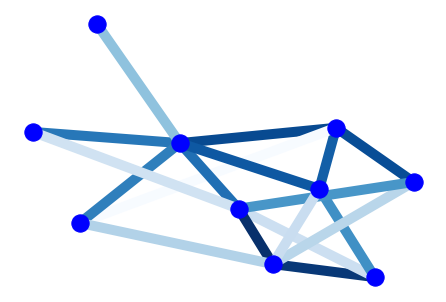

In [33]:
import matplotlib.pyplot as plt
import networkx as nx
import random

G = nx.gnp_random_graph(10,0.3)
for u,v,d in G.edges(data=True):
    d['weight'] = random.random()

edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

pos = nx.spring_layout(G)
nx.draw(G, pos, node_color='b', edgelist=edges, edge_color=weights, width=10.0, edge_cmap=plt.cm.Blues)
plt.savefig('edges.png')

In [43]:
nx.get_edge_attributes(G,'weight').values()

dict_values([0.8650366748842452, 0.19853212229645312, 0.5665684560157748, 0.7972566377078478, 0.26150784405580574, 0.5438727825273278, 0.8068706823468621, 0.7316131883182558, 0.0020488002089106283, 0.6499530724068349, 0.6774610139281472, 0.759140590826736, 0.6264468968449864, 0.37000753994482394, 0.8955199094576959, 0.21270542777757218, 0.2828742542310284, 0.17902822345891])

In [ ]:
### Old code for plotting on a seaborn map 

# fig, ax = plt.subplots(2, 1, figsize=(9, 18))
# g1 = sns.scatterplot(x='longitude', y='latitude', size='usage', hue='usage', data=stations_use, s=20, ax=ax[0])

# xlim = [-77.06, -76.98]
# ylim = [38.85, 38.94]
# ax[1].set(xlim=xlim, ylim=ylim)
# g2 = sns.scatterplot(x='longitude', y='latitude', size='usage', sizes=(20, 300), hue='usage', data=stations_use, ax=ax[1])
# for i in range(5):
#     x_coor = stations_use.iloc[i, ].longitude
#     y_coor = stations_use.iloc[i, ].latitude
#     name = stations_use.iloc[i, ].station
#     g2.text(x_coor, y_coor, name, horizontalalignment='left', size='medium', color='black', weight='semibold')

# for shape in sf.shapeRecords():
#         x = [i[0] for i in shape.shape.points[:]]
#         y = [i[1] for i in shape.shape.points[:]]
#         plt.plot(x, y, 'k')


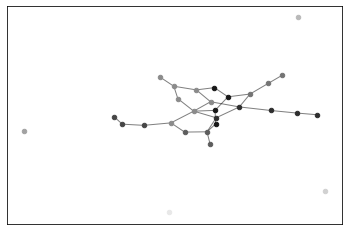

In [94]:
#other example to display a graph with its community :
#better with karate_graph() as defined in networkx examples
#erdos renyi don't have true community structure
G = nx.erdos_renyi_graph(30, 0.05)
#first compute the best partition
partition = community.best_partition(G)
#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count += 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

some comments about turnover, 

### Are station usage proportional to the station size?

#### First, look at distribution of capacity

In [ ]:
# There is at least one station in stations_use that is missing capacity 
# because it wasn't in the original data and I couldn't find capacity from the web. Omit that station
su = stations_use[~stations_use.capacity.isna()]
sns.distplot(su.capacity[~su.capacity.isna()], kde=False)

In [ ]:
from scipy.stats import pearsonr
corr, _ = pearsonr(su.usage, su.capacity)
corr

In [ ]:
sns.lmplot(x="usage", y="capacity", data=su)

In [ ]:
from scipy.stats import spearmanr
corr, _ = spearmanr(su.usage, su.capacity)
corr

## Bike Usage

In [ ]:
df.groupby('bike_number').size().to_frame()